# Feature Extraction Twitter Sentiment Analysis

In sentiment analysis, we detect tweets that have negative sentiment, i.e, racist, sexist or general hate speech. Here, tweets with a label '1' denotes a negative tweet, while '0' denotes the absence of hate speech in the tweet.

For textual data, we need to perform feature extraction in order to train a supervised machine learning model. In this notebook, our main goal is to **explore the different feature extraction methods**, and not to optimise the performance of the model.

We extract features using the following:
1. Bag of Words Features
2. TF-IDF features
3. Word Embeddings

The details for the same will be discussed alongside their implementation.

In [1]:
#Loading Libraries

#text analysis
import re 
import nltk 
import string

#data processing
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt 
import seaborn as sns



%matplotlib inline

In [2]:
pd.set_option("display.max_colwidth", 300)
#This helps us see the dataframes in a more visually pleasing manner

In [3]:
train=pd.read_csv("/data/train.csv")
test=pd.read_csv("/data/test.csv")
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


## Data Exploration

Understanding the labelled dataset.

In [4]:
#Typical non-negative tweets

train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [5]:
#Typical negative tweets
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


Right off the bat we can see that usernames, numerics and special characters are not necesarry to classify the sentiment of the tweet. What is essential, however, is the hashtag. 

A good rule of thumb while dealing with twitter (or social media) data is to keep the hashtags, as they can explicitly denote the emotion, tone, or subject of the tweet.

In [6]:
#Dataset shape
train.shape, test.shape

((31962, 3), (17197, 2))

In [7]:
#Dataset Distribution

train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

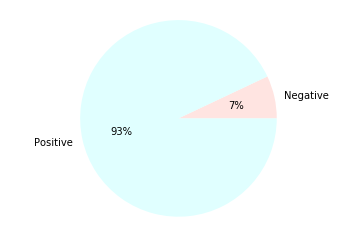

In [8]:
#Visualising
%matplotlib inline

labels=['Negative', 'Positive']
colors = ['mistyrose','lightcyan']
sizes=[train['label'].value_counts()[1],
     train['label'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
plt.show()

As we can see, 93% of the training data is classified as non-racist/sexist. Thus, the dataset is imbalanced. 

Typically, a good way to deal with this is to resample the data (either oversampling the under-represented class, or undersampling the over-represented class), but we will avoid making changes to the dataset here. 

Instead, we will just be wary of using Accuracy as our evaluation metric, and instead use the F1-Score. While this doesnt particularly solve the problem of having an unbalanced dataset, it will reduce the chances of misinterpretting our results.

A good explanation of how you can deal with imbalanced data can be found [here](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18).

In [ ]:
#Checking the distribution of length of tweets in training and test set

length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets", color='mistyrose')
plt.hist(length_test, bins=20, label="test_tweets", color='darksalmon')
plt.legend()
plt.show()

The distribution of the tweet length is pretty much the same.

## Preprocessing and Cleaning the Data

For cleaning the data, we will do the following:

1. Combine both test and training set so we can preprocess both together
2. Remove redundant characters- numerics, special characters (not hashtags), short words, usernames(@user)
3. Tokenise the processed tweet
4. Stemming- strip suffixes to get the root word

### Combining the Train and Test Sets

In [9]:
#combine test and train set
combine= train.append(test,ignore_index=True, sort=True)

### Removing Redundant Characters and Words

In [10]:
#function that removes a specific user-defined pattern from text, which we can use later
def remove_pattern(input_txt, pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    return input_txt


In [11]:
#create a new column "tidy_tweet" which has our processed, tidy treat without redundancies
#removes '@user'; regular expression "@[\w]*" returns anything starting with @

combine['tidy_tweet'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

In [12]:
#remove special characters, except #
combine['tidy_tweet'] = combine['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [13]:
#remove short words
combine['tidy_tweet']=combine['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

In [14]:
combine.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


### Tokenising the Tweets

Here, tokens are the individual words of the tweet, so we just split it.

In [15]:
#tokenising
tokenised_tweet= combine['tidy_tweet'].apply(lambda x: x.split())
tokenised_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

### Normalizing the Text

Using the Porter Stemmer to normalise the tweets. This reduces the vocabulary size, while more or less preserving the sentiment and semantics.

In [16]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenised_tweet = tokenised_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenised_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [17]:
#put all tokens back as the tidy_tweet
for i in range(len(tokenised_tweet)):
    tokenised_tweet[i] = ' '.join(tokenised_tweet[i])
combine['tidy_tweet']=tokenised_tweet


combine.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


## Data Analysis and Visualisation

We will analyse the text of the tweet and its relation to the sentiment with the following:

1. Wordcloud: Most used words (have bigger fonts), for positive and negative tweets. [Reference](https://amueller.github.io/word_cloud/).
2. Hashtags: Analyse the effect of hashtags on the tweet sentiment.


### Word Cloud Generation

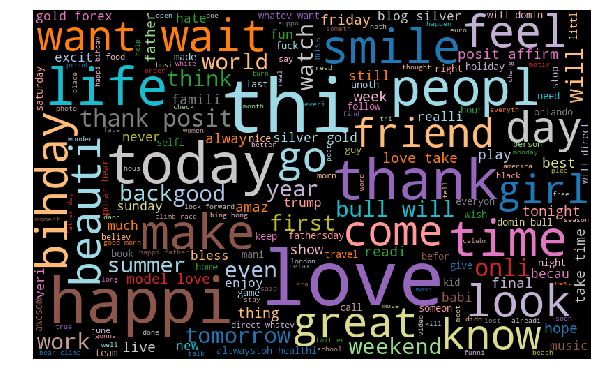

In [18]:
#wordcloud generation for all tweets

all_words=' '.join([text for text in combine['tidy_tweet']])
from wordcloud import WordCloud
word_cloud=WordCloud(width=800, height=500, random_state=21,max_font_size=110,colormap='tab20').generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

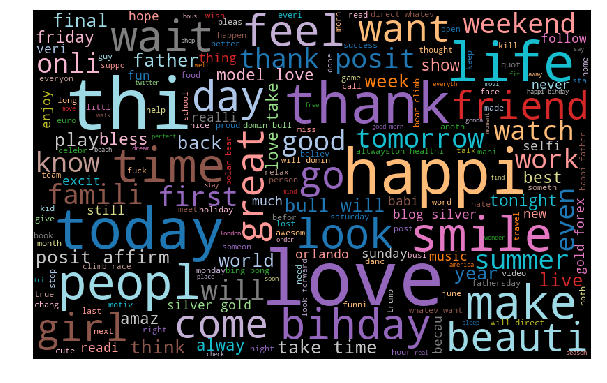

In [19]:
#wordcloud for positive (non-racist) tweets
non_negative_words=' '.join([text for text in combine['tidy_tweet'][combine['label']==0]])
from wordcloud import WordCloud
word_cloud=WordCloud(width=800, height=500, random_state=21,max_font_size=110,colormap='tab20').generate(non_negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

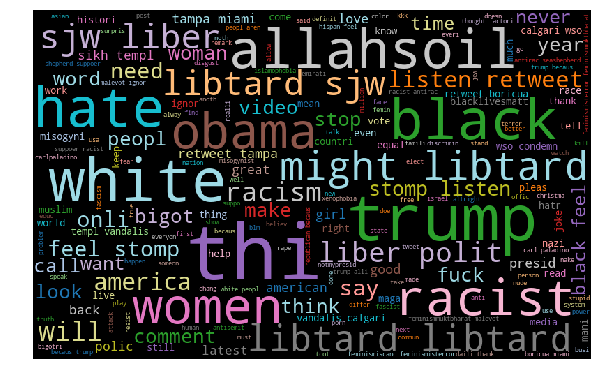

In [20]:
#wordcloud for negative (racist) tweets
negative_words=' '.join([text for text in combine['tidy_tweet'][combine['label']==1]])
from wordcloud import WordCloud
word_cloud=WordCloud(width=800, height=500, random_state=21,max_font_size=110,colormap='tab20').generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Hashtag Analysis

In [21]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [22]:
#hashtag list for non negative tweets
HT_non_negative = hashtag_extract(combine['tidy_tweet'][combine['label'] == 0])

#hashtag list for negative tweets
HT_negative = hashtag_extract(combine['tidy_tweet'][combine['label'] == 1])

#unnest list
HT_non_negative = sum(HT_non_negative,[])
HT_negative = sum(HT_negative,[])

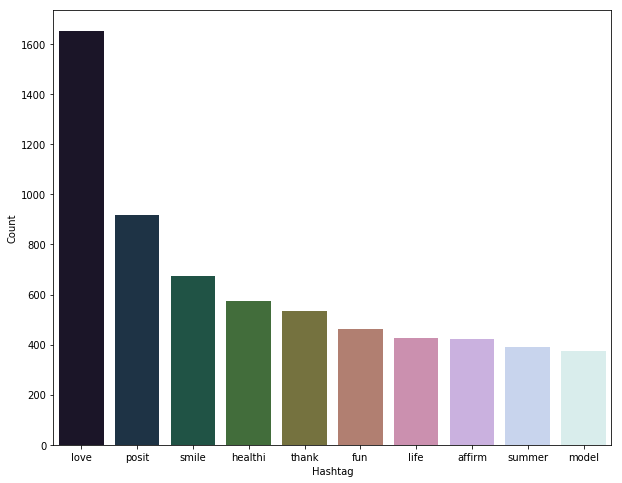

In [23]:
#most used hashtag for non negative tweets

a = nltk.FreqDist(HT_non_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(10,8))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",palette="cubehelix")
ax.set(ylabel = 'Count')
plt.show()

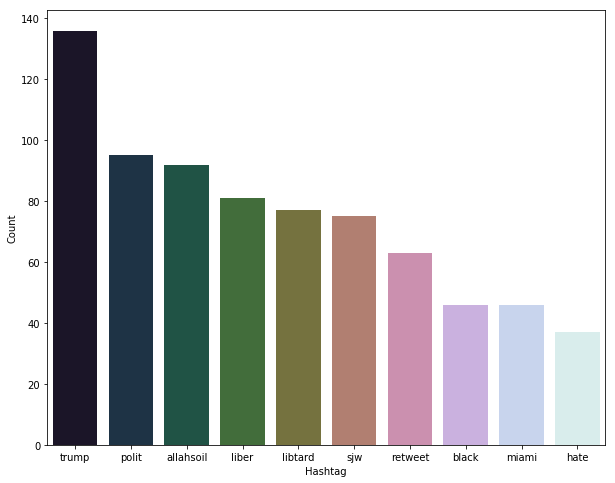

In [24]:
#most negative hashtags
b = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(b.keys()),
                  'Count': list(b.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(10,8))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",palette="cubehelix")
ax.set(ylabel = 'Count')
plt.show()

As we see, hashtags are quite important in our dataset, as they have explicit negative/non-negative associations.

## Feature Extration

**Extracting Features from Text**

1. Bag Of Words Features: creates a matrix of the unique tokens (in all documents in a corpus) and their respective frequencies. This will not see the context of the words, merely the presence of the word. [Reference](https://machinelearningmastery.com/gentle-introduction-bag-words-model/)

2. TF-IDF Features: like BOW, but gives more weight to rare words. That is, words that occur frequently in only a few tweets are given more importance than words that occur in all tweets. [Reference](https://medium.com/acing-ai/what-is-tf-idf-in-feature-engineering-7f1ba81982bd) 

3. Word Embeddings (Word2Vec): these are representations of texts that preserve the semantics (in a way). Here, words with similar meaning will be mapped to a similar representation. Word2Vec gives a numerical representation of a word,that preserve the relationship between words (such as synonyms or antonyms). [Reference](http://https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) 

### Bag of Words Features

In [25]:
#bag of word features
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow=bow_vectorizer.fit_transform(combine['tidy_tweet'])

bow.shape

(49159, 1000)

### TF-IDF Features

In [26]:
#TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf=tfidf_vectorizer.fit_transform(combine['tidy_tweet'])

tfidf.shape

(49159, 1000)

### Word2Vec Embeddings

In [27]:
import gensim
tokenized_tweet = combine['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combine['tidy_tweet']), epochs=20)

(6510028, 7536020)

In [28]:
#Find most similar words in the corpus for a given word

model_w2v.wv.most_similar(positive="trump")

/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.5663895606994629),
 ('phoni', 0.5387540459632874),
 ('unstabl', 0.5368220806121826),
 ('#delegaterevolt', 0.52967369556427),
 ('hillari', 0.5279616713523865),
 ('melo', 0.5261373519897461),
 ('unfit', 0.5218153595924377),
 ('jibe', 0.5193105936050415),
 ('unfavor', 0.5156388878822327),
 ('tomlin', 0.514748215675354)]

Creating vectors for tweets

In [29]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [30]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)

wordvec_df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(49159, 200)

Word2Vec has 200 features, as opposed to the 1000 features in BOW and TFIDF. What does this do? Save space and time.

## Building the Model

We will use a Logistic Regression model to test the performance using our three different feature sets.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### Bag of Words Features

In [32]:
#BOG feature model

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

xtrain_bow, xval_bow,ytrain,yval=train_test_split(train_bow,train['label'],random_state=42,test_size=0.3)

lr=LogisticRegression()
lr.fit(xtrain_bow,ytrain)

prediction=lr.predict_proba(xval_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yval,prediction_int)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5307820299500832

In [33]:
test_pred = lr.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int

submission = test[['id','label']]

#submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

### TFIDF Features

In [34]:
#TF-IDF
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yval.index]

lr.fit(xtrain_tfidf, ytrain)

prediction = lr.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yval, prediction_int)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5446507515473032

### Word2Vec Features

In [35]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yval.index,:]

In [36]:
lr.fit(xtrain_w2v, ytrain)

prediction = lr.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yval, prediction_int)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6056547619047619

As can be seen, Word2Vec embeddings outperform TFIDF and BOW.